<a href="https://colab.research.google.com/github/Hong-Hyun-Seung/upstage-basic-deeplearning/blob/main/focus_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install timm

     |████████████████████████████████| 376 kB 4.0 MB/s 


In [3]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time
from matplotlib import image
from torchvision import transforms, datasets, models
#from efficientnet_pytorch import EfficientNet
#import wandb
import time
import timm
import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import torchvision.datasets as dset
dataset = dset.ImageFolder(root="/content/drive/MyDrive/images/",
                           transform=transforms.Compose([
                                            #transforms.CenterCrop(384),
                                            transforms.Resize(256),
                                            transforms.ToTensor(),
                                             
                                            transforms.Normalize(mean = [0.5,0.5,0.5],
                                                                 std =[0.5,0.5,0.5])]))

In [5]:
print(len(dataset))

323


In [6]:
print(dataset[40])

(tensor([[[ 0.1373,  0.1216,  0.1373,  ...,  0.2392,  0.2471,  0.2392],
         [ 0.1294,  0.1216,  0.1294,  ...,  0.2392,  0.2392,  0.2314],
         [ 0.1216,  0.1294,  0.1294,  ...,  0.2314,  0.2314,  0.2235],
         ...,
         [-0.0275, -0.0196, -0.0275,  ...,  0.0118, -0.0275, -0.0353],
         [-0.0353, -0.0275, -0.0353,  ...,  0.0039, -0.0039, -0.0275],
         [-0.0431, -0.0510, -0.0588,  ..., -0.0039, -0.0118, -0.0353]],

        [[ 0.1608,  0.1373,  0.1373,  ...,  0.2471,  0.2471,  0.2314],
         [ 0.1529,  0.1373,  0.1373,  ...,  0.2471,  0.2471,  0.2314],
         [ 0.1529,  0.1451,  0.1373,  ...,  0.2471,  0.2392,  0.2235],
         ...,
         [ 0.0118,  0.0196,  0.0118,  ...,  0.0353,  0.0118,  0.0039],
         [ 0.0039,  0.0118,  0.0039,  ...,  0.0353,  0.0431,  0.0353],
         [-0.0039, -0.0118, -0.0196,  ...,  0.0353,  0.0431,  0.0353]],

        [[ 0.2314,  0.1843,  0.1686,  ...,  0.1373,  0.1686,  0.1922],
         [ 0.2157,  0.1843,  0.1686,  ...,  

# Train_Valid 분리

In [7]:
train_len = int(len(dataset) * 0.8)
print(train_len)
val_len = len(dataset) - train_len
print(val_len)
from torch.utils.data.dataset import random_split
train_dataset, val_dataset = random_split(dataset, [train_len,val_len])

258
65


In [8]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset = train_dataset, batch_size=20, shuffle = True, drop_last=True)    #통상 첨에 시작할때 batch는 64에서 128로 잡는다  
val_loader = DataLoader(dataset = val_dataset, batch_size=20, shuffle = True, drop_last=True)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.pretrained = models.resnet152(pretrained=True)
        #last_layer_features = self.pretrained.fc.in_features
        ### strip the last layer
        self.backbone = torch.nn.Sequential(*list(self.pretrained.children())[:-1])#self.backbone은 이제 resnet에서 convolution layer만 있는 상태이다!!
        #self.gender = nn.Linear(2048, 2)
        self.focus = nn.Sequential(nn.Linear(2048,500),
                                            nn.Linear(500,100),
                                           nn.Linear(100,2),
                                   nn.Softmax())
        '''
        self.mask = nn.Sequential(nn.Linear(2048,500),
                                            nn.Linear(500,100),
                                           nn.Linear(100,3),
                                 nn.Softmax())
        self.age = nn.Sequential(nn.Linear(2048,500),
                                            nn.Linear(500,100),
                                           nn.Linear(100,3),
                                nn.Softmax())
                                '''
    def forward(self, x):
        shared = self.backbone(x).squeeze()
        '''
        gender = self.gender(shared)
        mask = self.mask(shared)
        age = self.age(shared)
        '''
        focus = self.focus(shared)
        return focus
        #x = torch.randn([1,3,224,224])
        #output = self.backbone(x)
        #print(output.shape)
        #print(last_layer_features)

In [11]:
model = Model().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [12]:
def Train_and_Valid_check(model, model_name):
    from tqdm.notebook import tqdm
    MODEL_PATH ="multi_layer_saved"
    
    num_epochs = 10
    #start_time = time.time()

    for epoch in range(num_epochs):
        """ Training Phase """
        model.train()

        running_loss = 0.
        running_corrects = 0

        # load a batch data of images
        for img, focused in tqdm(train_loader):
            #inputs = inputs.to(device)
            '''
            gender = gender.to(device)
            mask = mask.to(device)
            age = age.to(device)
            '''
            focus = focused.to(device)
           # class_num = class_num.to(device)
            img = img.to(device)#img가 

            # forward inputs and get output
            optimizer.zero_grad()
            #gender_out, mask_out, age_out = model(img)
            focus_out = model(img)
            #outputs = model(img)
           # _, gender_preds = torch.max(gender_out, 1)
           # _, mask_preds = torch.max(mask_out,1)
           # _, age_preds = torch.max(age_out,1)
            _, focus_preds = torch.max(focus_out,1)
            #loss = loss_func(outputs, labels)
            '''
            gender_loss = loss_func(gender_out,gender)
            mask_loss = loss_func(mask_out, mask)
            age_loss = loss_func(age_out, age)
            '''
            focus_loss = loss_func(focus_out, focus)
            # get loss value and update the network weights
            
            #total_loss = (gender_loss + mask_loss + age_loss)/3
            #total_loss = gender_loss * 0.2 + mask_loss * 0.2 + age_loss * 0.6
            #total_loss.backward()
            focus_loss.backward()
            optimizer.step()
            
            #loss.backward()
            #optimizer.step()
            #print(img.size(0))
            #preds = mask_preds* 6 + gender_preds * 3 + age_preds
            preds = focus_preds
            running_loss += focus_loss.item() * img.size(0)#64개 만큼의 loss가 나온다 
            # loss.item() 으로 손실이 갖고 있는 스칼라 값을 가져올 수 있습니다.
        #딕셔너리.items()와 다른것 주의!!
            #running_corrects += torch.sum(preds == class_num.data)
            running_corrects += torch.sum(preds == focus.data)


        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% '.format(epoch, epoch_loss, epoch_acc))


        model.eval()

        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0

            for img, focused in tqdm(val_loader):#얼마나 진행됐고 얼마나 남았는지 알려줌
                '''
            gender = gender.to(device)
            mask = mask.to(device)
            age = age.to(device)
            '''
                focus = focused.to(device)
                img = img.to(device)#img가 

                #outputs = model(inputs)
                #gender_out, mask_out, age_out = model(img)
                focus_out = model(img)
                #_, preds = torch.max(outputs, 1)
                #_, gender_preds = torch.max(gender_out, 1)
                #_, mask_preds = torch.max(mask_out,1)
               # _, age_preds = torch.max(age_out,1)
                _, focus_preds = torch.max(focus_out, 1)
                #loss = loss_func(outputs, labels)
                #gender_loss = loss_func(gender_out,gender)
               # mask_loss = loss_func(mask_out, mask)
                #age_loss = loss_func(age_out, age)
                focus_loss = loss_func(focus_out, focus)
            # get loss value and update the network weights
            
                #total_loss = (gender_loss + mask_loss + age_loss)/3

                running_loss += focus_loss.item() * img.size(0)
                #preds = mask_preds* 6 + gender_preds * 3 + age_preds
                preds = focus_preds
                running_corrects += torch.sum(preds == focus.data)

            epoch_loss = running_loss / len(val_dataset)
            epoch_acc = running_corrects / len(val_dataset) * 100.
            #wandb.log({"val_acc":epoch_acc, "val_loss":epoch_loss})
            #wandb.log({"val_acc":epoch_acc, "val_loss":epoch_loss})
            print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% '.format(epoch, epoch_loss, epoch_acc))
        if not os.path.exists(MODEL_PATH):
            os.makedirs(MODEL_PATH)
        torch.save(model, os.path.join(MODEL_PATH, f"{model_name}_is_model_and_{10 + epoch}th_epoch.pt"))
        #os.path.join(MODEL_PATH, "hand_mademodel_with_new_csv.pt"

In [13]:
Train_and_Valid_check(model, "concentration_check")

  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[Train #0] Loss: 0.6321 Acc: 57.7519% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #0] Loss: 0.6143 Acc: 58.4615% 


  0%|          | 0/12 [00:00<?, ?it/s]

[Train #1] Loss: 0.6006 Acc: 56.9767% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #1] Loss: 0.5855 Acc: 60.0000% 


  0%|          | 0/12 [00:00<?, ?it/s]

[Train #2] Loss: 0.5711 Acc: 56.2015% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #2] Loss: 0.5482 Acc: 58.4615% 


  0%|          | 0/12 [00:00<?, ?it/s]

[Train #3] Loss: 0.5354 Acc: 61.2403% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #3] Loss: 0.5106 Acc: 64.6154% 


  0%|          | 0/12 [00:00<?, ?it/s]

[Train #4] Loss: 0.4981 Acc: 82.9457% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #4] Loss: 0.4600 Acc: 83.0769% 


  0%|          | 0/12 [00:00<?, ?it/s]

[Train #5] Loss: 0.4524 Acc: 89.9225% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #5] Loss: 0.4326 Acc: 89.2308% 


  0%|          | 0/12 [00:00<?, ?it/s]

[Train #6] Loss: 0.4254 Acc: 89.5349% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #6] Loss: 0.3944 Acc: 90.7692% 


  0%|          | 0/12 [00:00<?, ?it/s]

[Train #7] Loss: 0.3769 Acc: 91.4729% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #7] Loss: 0.3654 Acc: 90.7692% 


  0%|          | 0/12 [00:00<?, ?it/s]

[Train #8] Loss: 0.3598 Acc: 90.6977% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #8] Loss: 0.3467 Acc: 90.7692% 


  0%|          | 0/12 [00:00<?, ?it/s]

[Train #9] Loss: 0.3336 Acc: 92.6357% 


  0%|          | 0/3 [00:00<?, ?it/s]

[Validation #9] Loss: 0.3301 Acc: 90.7692% 


### 여기 아래 코드 그대로 따라 하시면 됩니다.

# 들어온 이미지 확인 

In [67]:
from PIL import Image
test_image = Image.open("/content/drive/MyDrive/images/focused/2_focused.jpg") #집중하는 이미지가 있는 경로를 써줍니다
#test_image = Image.open("/content/drive/MyDrive/images/unfocused/1_unfocused.jpg")#집중 안하는 이미지 있는 경로를 써줍니다

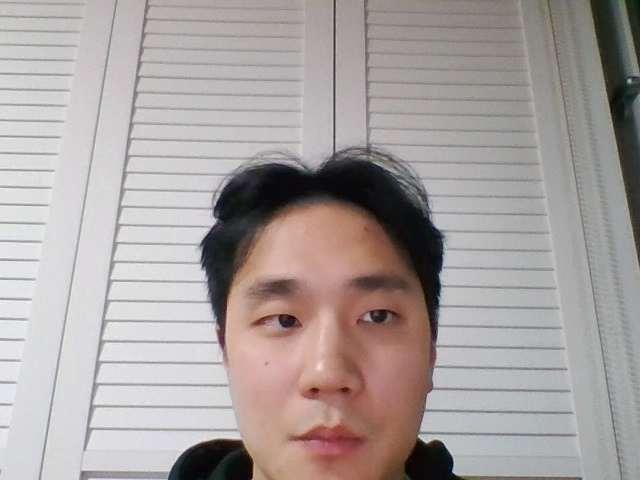

In [68]:
from IPython.display import Image
display(test_image)

#모델 불러오기

In [69]:
device = torch.device('cuda')
model = torch.load("/content/multi_layer_saved/concentration_check_is_model_and_19th_epoch.pt") #모델 저장 경로를 써주면 됩니다.(제가 드린 pt파일 저장 경로)
model.eval()

Model(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

# Image를 ai모델("~.pt")에 들어가기 알맞은 형태로 바꿔줍니다

In [70]:
 transform=transforms.Compose([   transforms.Resize(256),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean = [0.5,0.5,0.5],
                                                        std =[0.5,0.5,0.5])])

In [71]:
model_input = transform(test_image)

# 모델에 넣기및 출력 확인

In [72]:
image = model_input.to(device)
pred = model(image.unsqueeze(0))
pred = pred.argmax(dim=-1)
answer = pred.item()
#print(answer)
if answer == 0:
  print("집중")
else:
  print("비집중")

집중


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
